In [50]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras.layers import UpSampling2D
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)


In [51]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [52]:
## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)




Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

### Shape of data

In [53]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (1772, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### CNN_LSTM
#### 4 Convolution block
#### FC+ 2LSTM 
#### Activation = LeakyRelu
#### Filters = 20, 40, 80, 160

In [54]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

#activation=LeakyReLU(alpha=0.2)
activation='relu'

#kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=20, kernel_size=(10,1), padding='same', activation=activation,input_shape=(250,1,22), kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=40, kernel_size=(10,1), padding='same', activation=activation, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=80, kernel_size=(10,1), padding='same', activation=activation, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=160, kernel_size=(10,1), padding='same', activation=activation, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 5
hybrid_cnn_lstm_model.add(Conv2D(filters=160, kernel_size=(10,1), padding='same', activation=activation, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()







Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 250, 1, 20)        4420      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 84, 1, 20)        0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 84, 1, 20)        80        
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 84, 1, 20)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 84, 1, 40)         8040      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 28, 1, 40)       

In [55]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [56]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=124,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/100
57/57 [==============================] - 7s 80ms/step - loss: 1.7070 - accuracy: 0.2691 - val_loss: 1.6719 - val_accuracy: 0.3380
Epoch 2/100
57/57 [==============================] - 4s 74ms/step - loss: 1.6443 - accuracy: 0.3211 - val_loss: 1.5962 - val_accuracy: 0.3600
Epoch 3/100
57/57 [==============================] - 4s 78ms/step - loss: 1.5760 - accuracy: 0.3622 - val_loss: 1.5480 - val_accuracy: 0.3840
Epoch 4/100
57/57 [==============================] - 6s 100ms/step - loss: 1.5171 - accuracy: 0.3822 - val_loss: 1.5192 - val_accuracy: 0.3873
Epoch 5/100
57/57 [==============================] - 6s 105ms/step - loss: 1.4558 - accuracy: 0.4270 - val_loss: 1.4778 - val_accuracy: 0.4160
Epoch 6/100
57/57 [==============================] - 6s 104ms/step - loss: 1.4114 - accuracy: 0.4524 - val_loss: 1.5049 - val_accuracy: 0.4000
Epoch 7/100
57/57 [==============================] - 6s 105ms/step - loss: 1.3702 - accuracy: 0.4770 - val_loss: 1.4596 - val_accuracy: 0.4260
Ep

Epoch 58/100
57/57 [==============================] - 6s 101ms/step - loss: 0.8577 - accuracy: 0.8091 - val_loss: 1.2679 - val_accuracy: 0.6573
Epoch 59/100
57/57 [==============================] - 6s 101ms/step - loss: 0.8530 - accuracy: 0.8068 - val_loss: 1.2957 - val_accuracy: 0.6553
Epoch 60/100
57/57 [==============================] - 6s 101ms/step - loss: 0.8482 - accuracy: 0.8089 - val_loss: 1.2865 - val_accuracy: 0.6600
Epoch 61/100
57/57 [==============================] - 6s 111ms/step - loss: 0.8394 - accuracy: 0.8102 - val_loss: 1.3190 - val_accuracy: 0.6327
Epoch 62/100
57/57 [==============================] - 6s 103ms/step - loss: 0.8219 - accuracy: 0.8157 - val_loss: 1.3183 - val_accuracy: 0.6640
Epoch 63/100
57/57 [==============================] - 6s 105ms/step - loss: 0.8210 - accuracy: 0.8210 - val_loss: 1.2844 - val_accuracy: 0.6560
Epoch 64/100
57/57 [==============================] - 6s 100ms/step - loss: 0.8162 - accuracy: 0.8230 - val_loss: 1.2967 - val_accuracy:

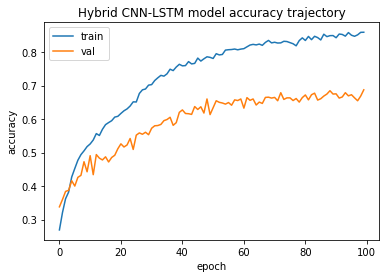

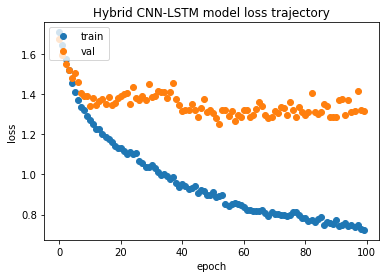

In [57]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.693566620349884


56/56 [==============================] - 1s 10ms/step


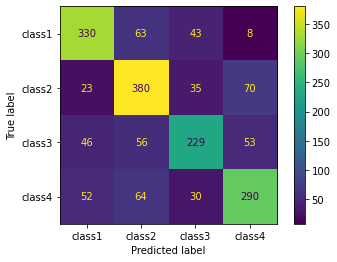

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_pred = hybrid_cnn_lstm_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

# Display confusion matrix
classes = ['class1', 'class2', 'class3', 'class4']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot()
plt.show()


In [60]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test data
y_pred = hybrid_cnn_lstm_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
target_names = ['class1', 'class2', 'class3', 'class4']
report = classification_report(y_true_labels, y_pred_labels, target_names=target_names)

# Print classification report
print(report)


56/56 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

      class1       0.73      0.74      0.74       444
      class2       0.67      0.75      0.71       508
      class3       0.68      0.60      0.64       384
      class4       0.69      0.67      0.68       436

    accuracy                           0.69      1772
   macro avg       0.69      0.69      0.69      1772
weighted avg       0.69      0.69      0.69      1772

